# This file displays how to various simulations. The circles added to the figures display the inner and outer working angles of $3\lambda/D$ and $9\lambda/D$ respectively.

### Begin by importing the necessary modules and functions.

In [6]:
import astropy.io.fits as fits
import astropy.units as u
import os
import numpy as np
import time
from pathlib import Path
home_path = Path(os.getcwd())

import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from matplotlib.patches import Circle
plt.rcParams.update({'image.origin': 'lower',
                     'image.interpolation':"nearest"})

from importlib import reload
import misc_functions
reload(misc_functions)
from misc_functions import load_interpped_A, closest_PSF, run_sim_forloop, run_sim_standard
from misc_functions import setup_ipac_interpfun, setup_prop_interpfun, setup_prop_dm_interpfun

lambda0_m = 575e-9
D = 2.3631
mas_per_lamD = lambda0_m * 360.0 * 3600.0 / (2 * np.pi * D) * 1000    # mas per lambda0/D
as_per_lamD = mas_per_lamD/1000

nzodi = 256
nprop = 256
nipac = 128

ipac_pxscl_lamD = 0.2
prop_pxscl_lamD = 0.1

ipac_pxscl_mas = ipac_pxscl_lamD*mas_per_lamD # define the different pixelscale
prop_pxscl_mas = prop_pxscl_lamD*mas_per_lamD

sim_exmax = (nipac/2)*ipac_pxscl_lamD # define extent of simulation figures in lamD
sim_extent = [-sim_exmax,sim_exmax,-sim_exmax,sim_exmax]

## Load in a zodiacal scene from the datacube of masked scenes. Choose which incliniation is desired.

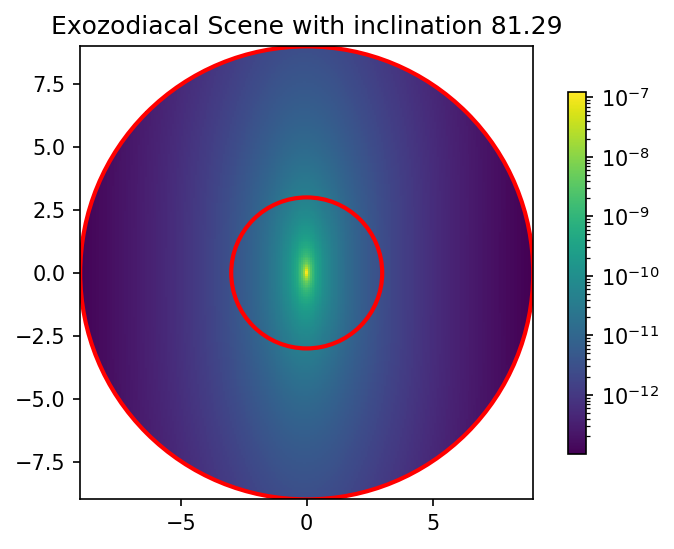

In [2]:
zodinum = 28 # choose which scene within the datacube you want to use, different inclination for the scenes
zodi_fname = 'zodipic_icube_10pc03.529mas_masked.fits'
zodi_path = home_path/'zodi_scenes'/zodi_fname

zodi_cube = fits.getdata(zodi_path)
zodi_cube_header = fits.getheader(zodi_path)
zodi_pxscl = zodi_cube_header['PIXELSCL']*u.arcsec # pixel scale is 3.529

start = 0
stop = 31
step = 1
incs = np.arange(start,stop+step,step)/stop*90 # generate array of inclinations within the zodiacal scenes file
zodi = zodi_cube[zodinum,:,:]

fig, ax = plt.subplots(nrows=1, ncols=1, dpi=150 )

exmax = (nzodi/2)*zodi_pxscl.value/as_per_lamD # define extent in lamD
exmin = -exmax
extent = [exmin,exmax,exmin,exmax]

im = ax.imshow(zodi, norm=LogNorm(), cmap=plt.get_cmap('viridis'), extent=extent)
circ_in = Circle((0,0),3,edgecolor='red', facecolor='none',lw=2)
circ_out = Circle((0,0),9,edgecolor='red', facecolor='none',lw=2)
ax.add_patch(circ_in)
ax.add_patch(circ_out)
ax.set_title('Exozodiacal Scene with inclination {:.2f}'.format(incs[zodinum]), fontsize=12)
fig.colorbar(im, ax=ax, shrink=0.8) 

## Choose the parametres for how to run the simulation, such as which PSFs to use, what the corresponding number of pixels is, and which interpolation method to use.

In [7]:
method = 'nearest' # choose either nearest or linear
psftype = 'ipac' # choose either ipac, prop, or propDMs
n = nipac # choose either nipac or nprop 

h5fname = 'interpped_CGI_HLC_'+psftype+'_3.529_'+method+'.h5' # choose the file from which to load the matrix
print(h5fname)

interpped_CGI_HLC_ipac_3.529_nearest.h5


## Use the for-loop method if the matrices are too large for comuptational memory.

Loading interpolated PSFs from /groups/douglase/Interpped_PSFs/interpped_CGI_HLC_ipac_3.529_nearest.h5.
Simulation done in 5.7129


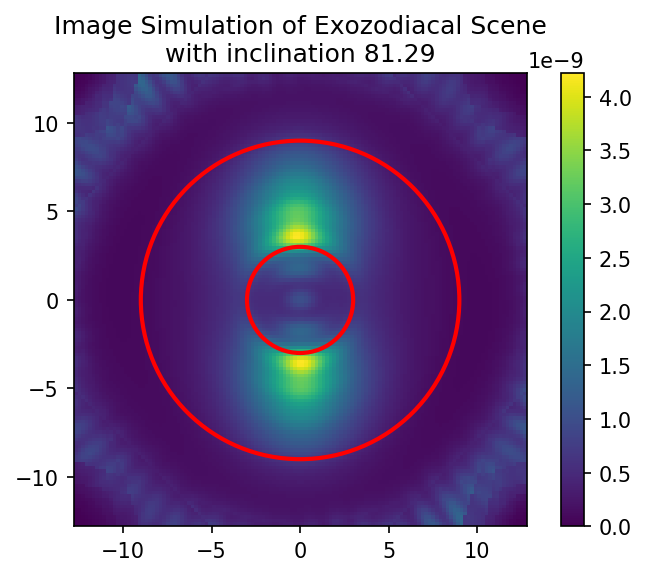

In [9]:
sim_loop = run_sim_forloop(zodi,h5fname,n)

fig, ax = plt.subplots(nrows=1, ncols=1, dpi=150 )

im = ax.imshow(sim_loop, cmap=plt.get_cmap('viridis'), extent=sim_extent)
circ_in = Circle((0,0),3,edgecolor='red', facecolor='none',lw=2)
circ_out = Circle((0,0),9,edgecolor='red', facecolor='none',lw=2)
ax.add_patch(circ_in)
ax.add_patch(circ_out)
ax.set_title('Image Simulation of Exozodiacal Scene\nwith inclination {:.2f}'.format(incs[zodinum]), fontsize=12)
fig.colorbar(im, ax=ax, shrink=1) 

## Save the simulation results.

In [35]:
sim_fname = 'simulation_results/sim_10pc3.529mas{:.2f}inc_'.format(incs[zodinum])+psftype+'_'+method+'.fits'
print('Saving simulation to '+sim_fname)
hdu = fits.PrimaryHDU(sim_loop)
hdu.writeto(sim_fname, overwrite=True)

Saving simulation to simulation_results/sim_10pc3.529mas81.29inc_propDMs_nearest.fits


## Load in one of the interpolated PSF arrays as a matrix if possible (if not, then just use the for-loop method) and perform the matrix-multiplication.

In [ ]:
A = load_interpped_A(h5fname)

zodi_flat = zodi.flatten()
sim = A.dot(zodi_flat).reshape(n,n)

fig, ax = plt.subplots(nrows=1, ncols=1, dpi=150 )

exmax = (nipac/2)*ipac_pxscl_lamD # define extent in lamD
exmin = -exmax
extent = [exmin,exmax,exmin,exmax]

im = ax.imshow(sim, cmap=plt.get_cmap('viridis'), extent=sim_extent)
circ_in = Circle((0,0),3,edgecolor='red', facecolor='none',lw=2)
circ_out = Circle((0,0),9,edgecolor='red', facecolor='none',lw=2)
ax.add_patch(circ_in)
ax.add_patch(circ_out)
ax.set_title('Image Simulation of Exozodiacal Scene\nwith inclination {:.2f}'.format(incs[zodinum]), fontsize=12)
fig.colorbar(im, ax=ax, shrink=0.8) 

## Run a simulation without using precomputed interpolated PSFs.

In [ ]:
hlc_interpfun = setup_ipac_interpfun(method=method)
sim_standard = run_sim_standard(zodi,hlc_interpfun,nipac)

fig, ax = plt.subplots(nrows=1, ncols=1, dpi=150 )

im = ax.imshow(sim_standard, cmap=plt.get_cmap('viridis'), extent=sim_extent)
circ_in = Circle((0,0),3,edgecolor='red', facecolor='none',lw=2)
circ_out = Circle((0,0),9,edgecolor='red', facecolor='none',lw=2)
ax.add_patch(circ_in)
ax.add_patch(circ_out)
ax.set_title('Image Simulation of Exozodiacal Scene\nwith inclination {:.2f}'.format(incs[zodinum]), fontsize=12)
fig.colorbar(im, ax=ax, shrink=0.8) 

## Compare the simulations to make sure they are the same, with some numerical computation variation.

In [ ]:
diff = sim-sim_loop
perdiff = diff/sim
fig, ax = plt.subplots(nrows=1, ncols=1, dpi=150 )

im = ax.imshow(perdiff, cmap=plt.get_cmap('viridis'), extent=sim_extent)
circ_in = Circle((0,0),3,edgecolor='red', facecolor='none',lw=2)
circ_out = Circle((0,0),9,edgecolor='red', facecolor='none',lw=2)
ax.add_patch(circ_in)
ax.add_patch(circ_out)
ax.set_title('Percent Difference between Simulations', fontsize=12)
fig.colorbar(im, ax=ax, shrink=0.8) 